# Comparison Opal data and ActiGraph data - multiple subjects

## Comparison

Data was collected simultaneously for walking in a lab setting (back and forth 10 times across a 30 m corridor) and while walking outside. The lab walk was more consistent speed, while the outside was varied (pausing, much more turning, up and down in elevation, etc).

Synchronization was performed by standing still for 10 seconds, jumping 3 times, standing still for another 10 seconds, and then starting the walking bout. Data was then manually synchronized to the jumping point in sync_imu_data.py.

In this file, let's compare MobGap outputs for the lab based walk.

# Raw data

Below we read and visualize the raw data for the lab based walking bout and outside data. Note that the Opal acceleration data is in m/s^2 and ActiGraph in units of g by default.

Using pq file data/apdm/apdm_subj1_lab_imu_data.parquet
Using actigraph file data/actigraph/actigraph_subj1_lab/data_acc_trimmed.csv


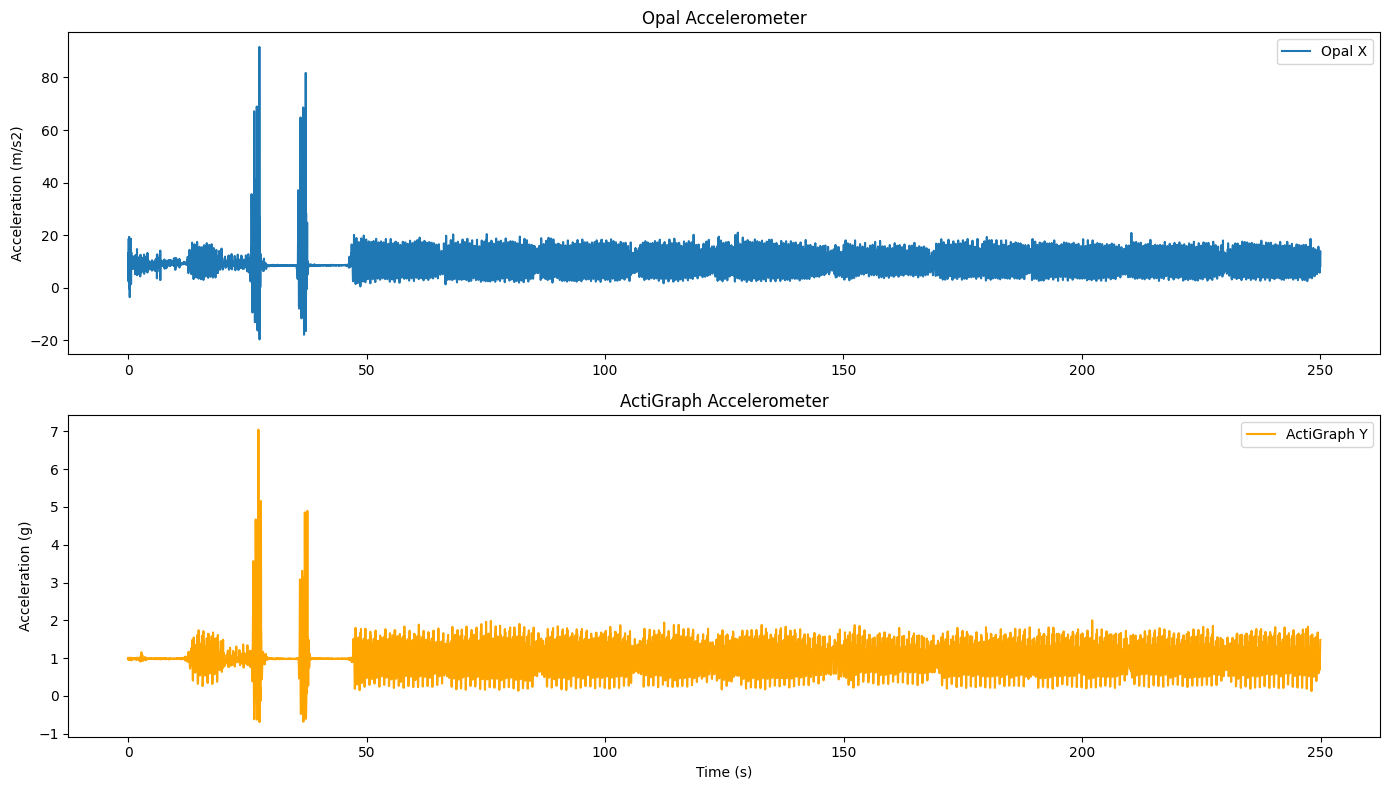

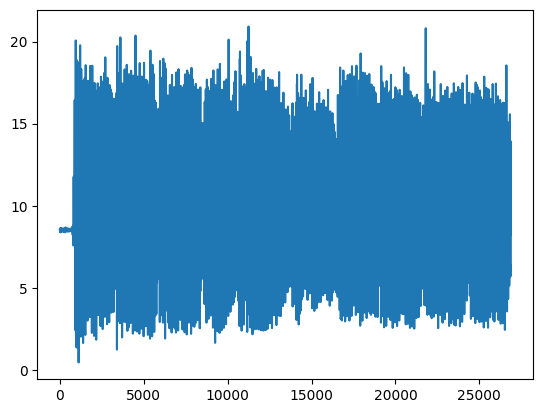

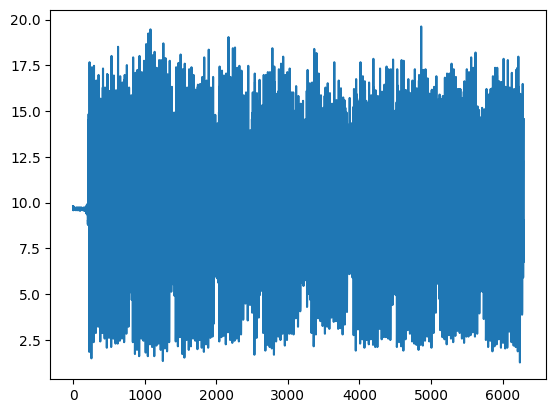

Using pq file data/apdm/apdm_subj2_lab_imu_data.parquet
Using actigraph file data/actigraph/actigraph_subj2_lab/data_acc_trimmed.csv


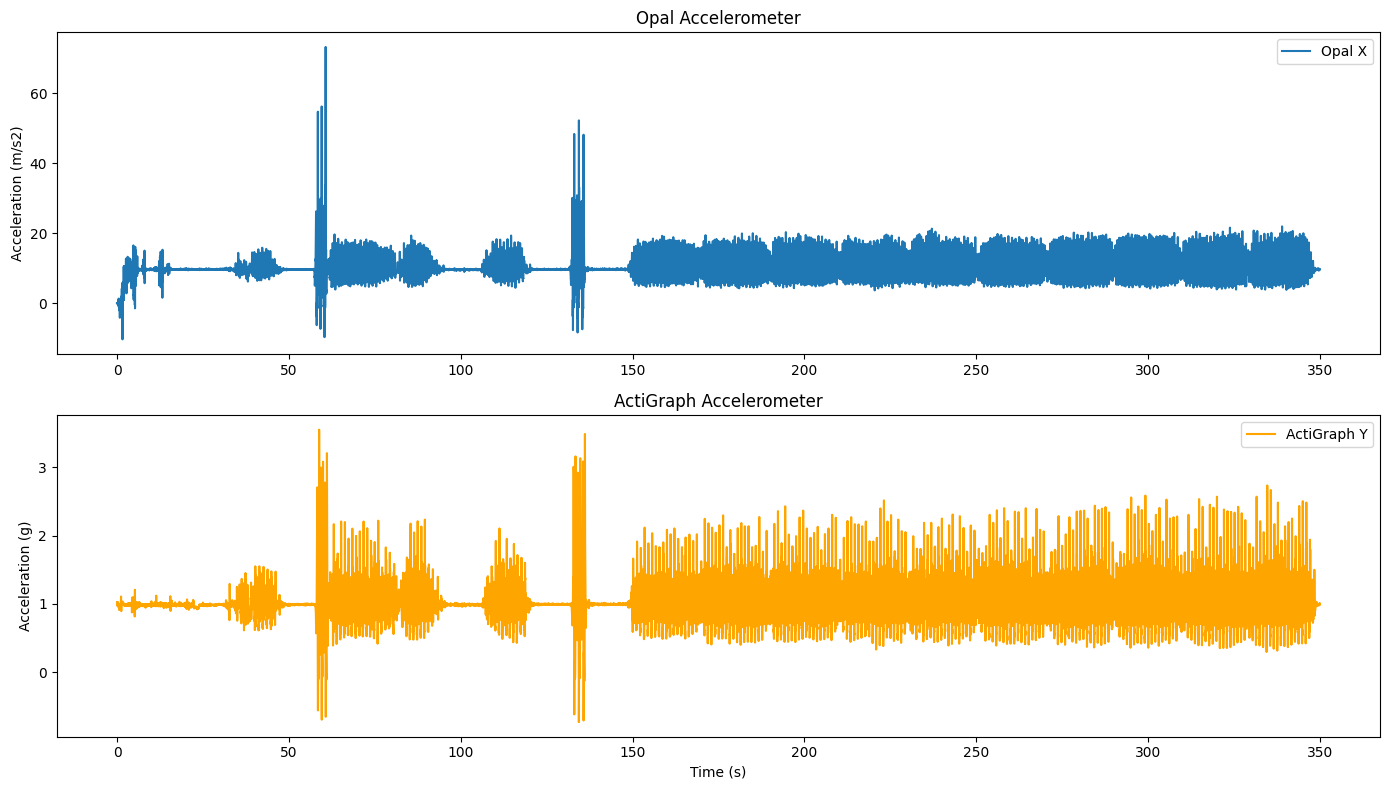

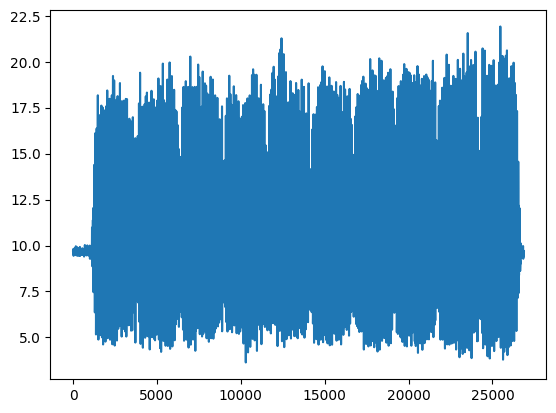

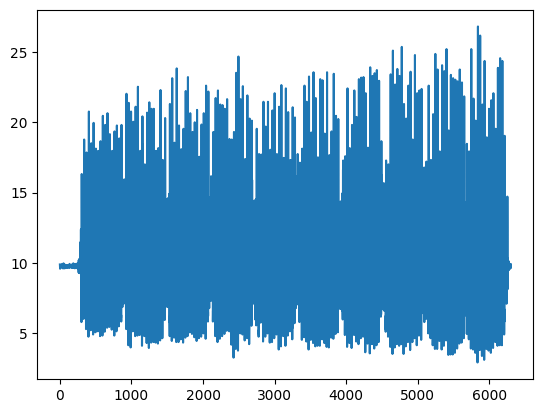

Using pq file data/apdm/apdm_subj1_outside_imu_data.parquet
Using actigraph file data/actigraph/actigraph_subj1_outside/data_acc_trimmed.csv


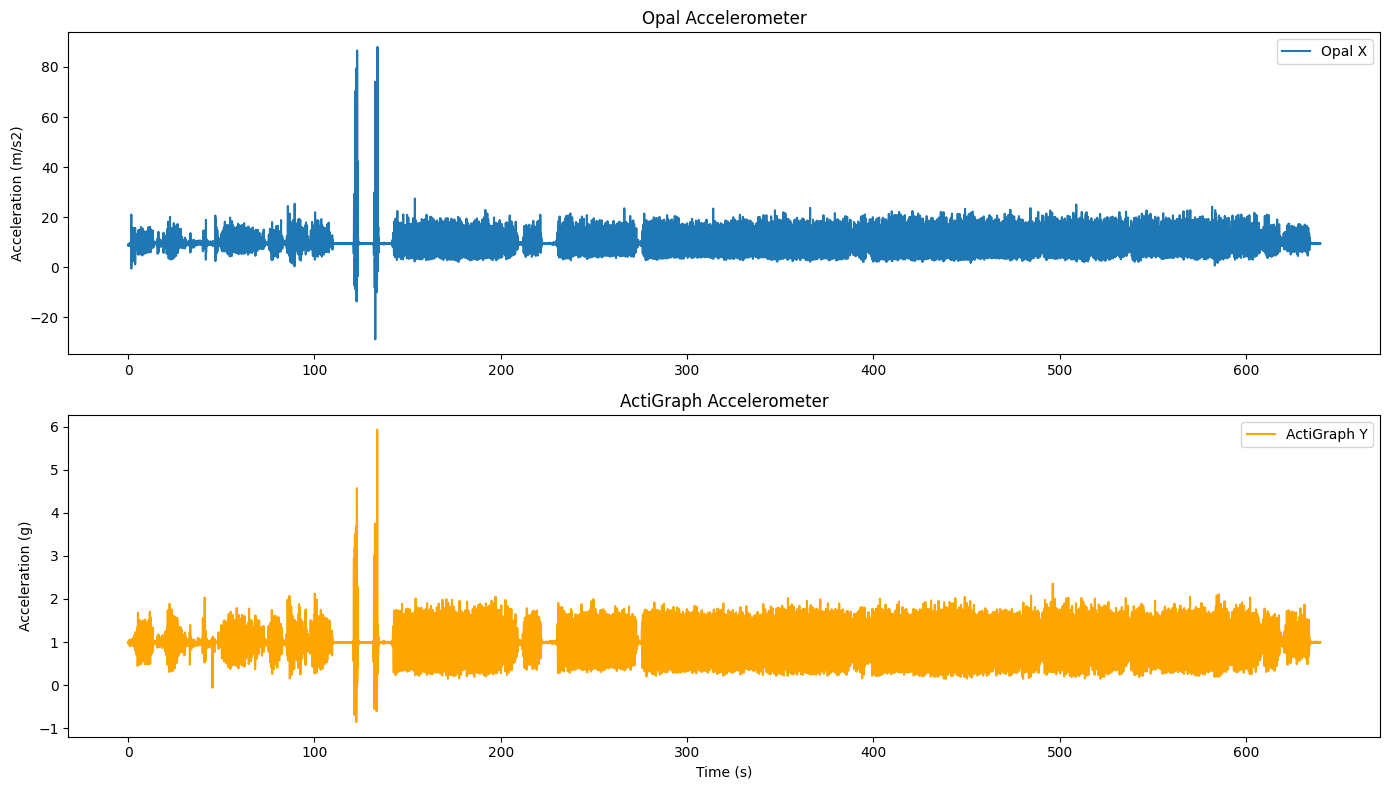

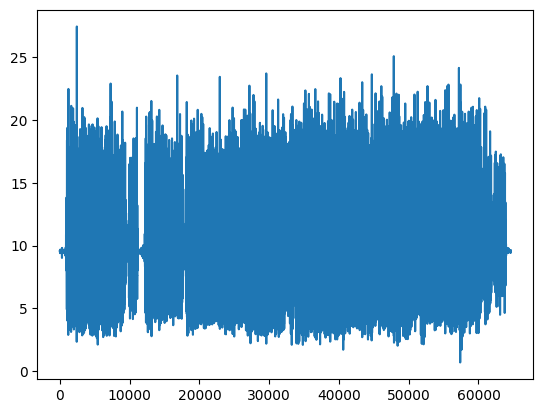

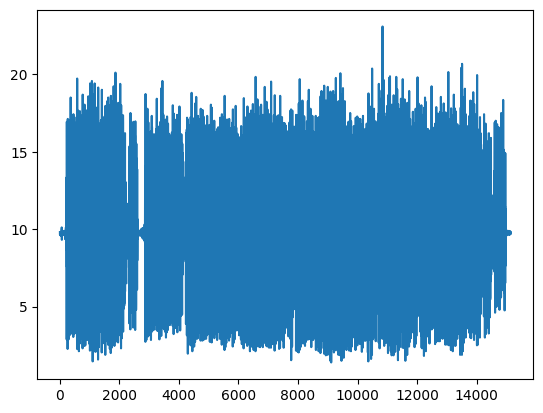

Using pq file data/apdm/apdm_subj2_outside_imu_data.parquet
Using actigraph file data/actigraph/actigraph_subj2_outside/data_acc_trimmed.csv


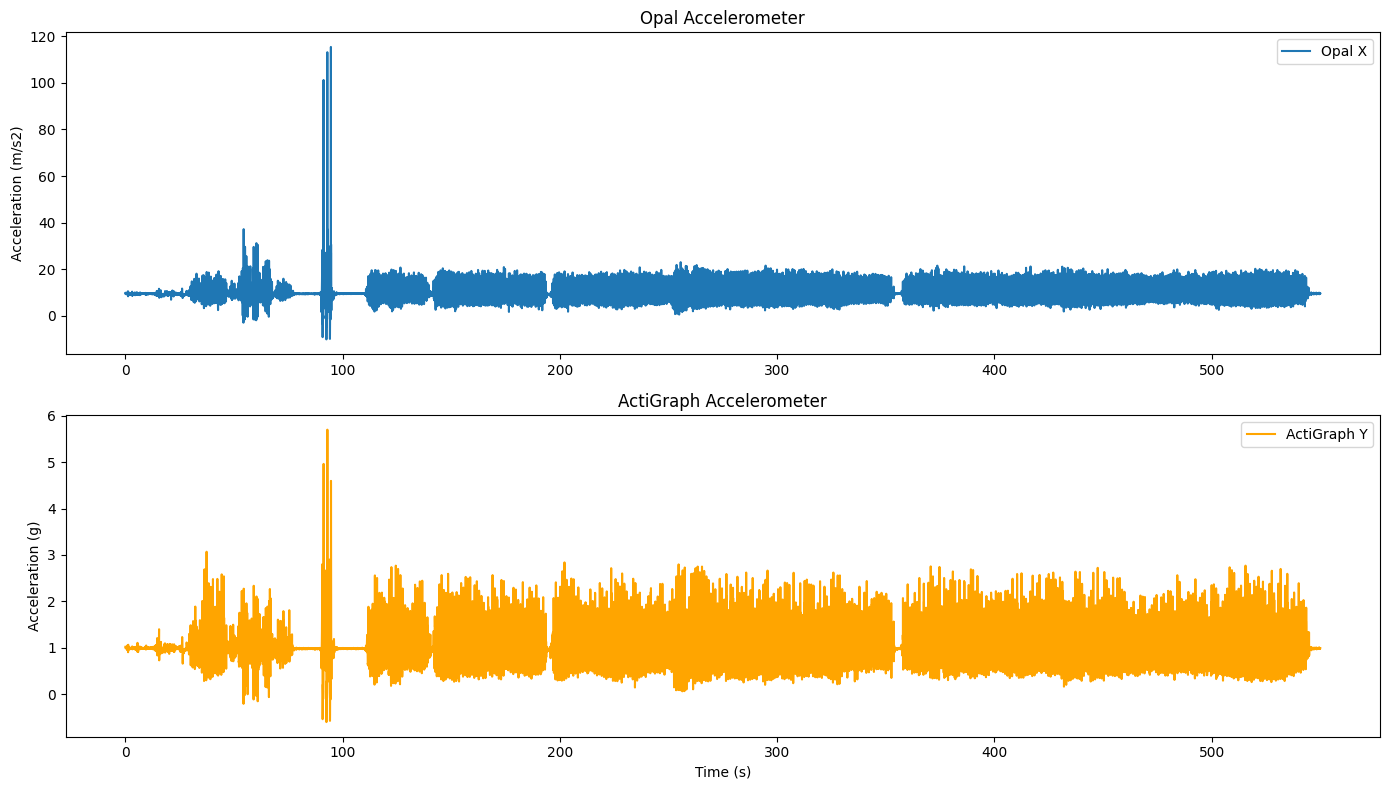

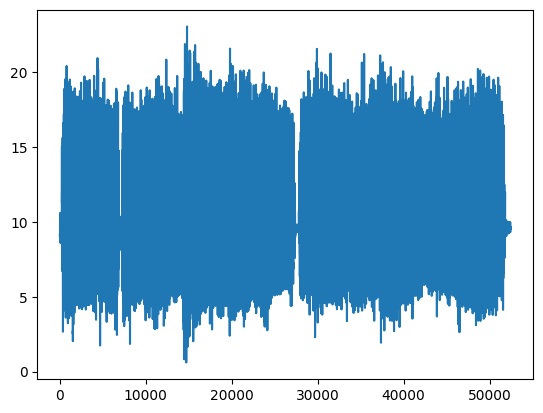

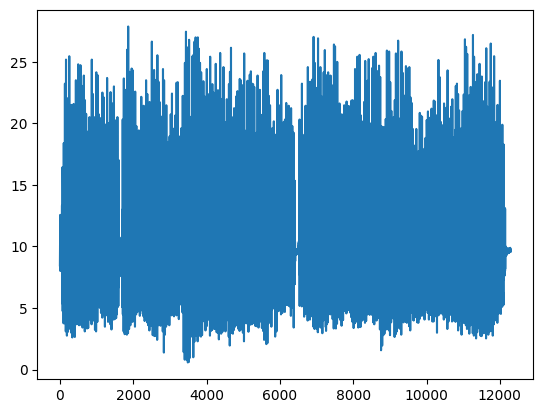

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


fs_opal = 128
fs_actigraph = 30

# Where all the data is stored
pq_files = ["data/apdm/apdm_subj1_lab_imu_data.parquet",
            "data/apdm/apdm_subj2_lab_imu_data.parquet",
            "data/apdm/apdm_subj1_outside_imu_data.parquet",
            "data/apdm/apdm_subj2_outside_imu_data.parquet",]

csv_files = ["data/actigraph/actigraph_subj1_lab/data_acc_trimmed.csv",
            "data/actigraph/actigraph_subj2_lab/data_acc_trimmed.csv",
            "data/actigraph/actigraph_subj1_outside/data_acc_trimmed.csv",
            "data/actigraph/actigraph_subj2_outside/data_acc_trimmed.csv",]

session_list = ["subj1_lab", "subj2_lab", "subj1_outside", "subj2_outside"]

t_end_list = [250, 350, 640, 550]
t_start_list = [40, 140, 135, 140]

def extract_condition_data(imu_data, session, sensor_position, start_time, end_time, fs_imu):

    # Get session data
    seek_column = f"{session}/{sensor_position}/Accelerometer"
    acc_data = imu_data.filter(regex=seek_column).to_numpy()
    seek_column = f"{session}/{sensor_position}/Gyroscope"
    gyr_data = imu_data.filter(regex=seek_column).to_numpy()
    seek_column = f"{session}/{sensor_position}/Magnetometer"
    mag_data = imu_data.filter(regex=seek_column).to_numpy()

    onset_idx = start_time*fs_imu
    end_idx = end_time*fs_imu

    # Cut to window
    acc_data = acc_data[onset_idx:end_idx,:]
    gyr_data = gyr_data[onset_idx:end_idx,:]
    mag_data = mag_data[onset_idx:end_idx,:]

    # Convert magnetometer data from microT to milliT
    mag_data = mag_data / 1000

    # For lumbar: as opposed to gaitmap frame, keep the original Opal frame
    # but reverse axis. This aligns with mobgap example dataset acceleration directions.
    if sensor_position == "LUMBAR":
        acc_data = -acc_data
        gyr_data = -gyr_data
        mag_data = -mag_data

    # mobgap and gaitmap wants gyro in deg/s, not rad/s as we have
    gyr_data = gyr_data * 57.2957795

    return acc_data, gyr_data, mag_data

def construct_gaitmap_dataframe(fs_imu, acc_data, gyro_data = None, mag_data = None, is_actigraph = False):
    time_axis = np.arange(0, acc_data.shape[0]) / fs_imu

    if gyro_data is None:
        gyro_data = np.zeros(acc_data.shape)
    if mag_data is None:
        mag_data = np.zeros(acc_data.shape)

    # ActiGraphs have their data in units of g, we want m/s2
    if is_actigraph:
        acc_data = acc_data*9.81

    # ActiGraphs have their axes oriented differently than MobGap data
    # so we need to replace X and Y
    if is_actigraph:
        data = {
            "acc_x": acc_data[:,1],
            "acc_y": acc_data[:,0],
            "acc_z": acc_data[:,2],
            "gyr_x": gyro_data[:,1],
            "gyr_y": gyro_data[:,0],
            "gyr_z": gyro_data[:,2],
            "mag_x": mag_data[:,1],
            "mag_y": mag_data[:,0],
            "mag_z": mag_data[:,2]
        }
    else:
        data = {
            "acc_x": acc_data[:,0],
            "acc_y": acc_data[:,1],
            "acc_z": acc_data[:,2],
            "gyr_x": gyro_data[:,0],
            "gyr_y": gyro_data[:,1],
            "gyr_z": gyro_data[:,2],
            "mag_x": mag_data[:,0],
            "mag_y": mag_data[:,1],
            "mag_z": mag_data[:,2]
        }
    df = pd.DataFrame(data, index=time_axis)

    df['samples'] = range(len(df))
    df.index = range(len(df))
    
    return df


# Get data for each session
session_opal_data = {}
session_actigraph_data = {}
for i in range(0,4):
    pq_file = pq_files[i]
    csv_file = csv_files[i]
    t_start = t_start_list[i]
    t_max = t_end_list[i]
    session = session_list[i]
    
    opal_imu_data = pd.read_parquet(pq_file)
    
    # Get acc data for session
    seek_column = "test" + "/LUMBAR/Accelerometer"
    acc_data_opal = opal_imu_data.filter(regex=seek_column).to_numpy()
    print("Using pq file " + pq_file)
    print("Using actigraph file " + csv_file)
    
    # Actigraph acc
    actigraph_data = pd.read_csv(csv_file)
    acc_data_actigraph = actigraph_data[['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']].to_numpy()
    
    # Create time axes
    t_actigraph = np.arange(0, len(acc_data_actigraph)) / fs_actigraph
    t_opal = np.arange(0, len(acc_data_opal)) / fs_opal
    
    # Trim end
    acc_data_opal_plot = acc_data_opal[0:t_max*fs_opal]
    acc_data_actigraph_plot = acc_data_actigraph[0:t_max*fs_actigraph]
    t_opal_plot = t_opal[0:t_max*fs_opal]
    t_actigraph_plot = t_actigraph[0:t_max*fs_actigraph]
    
    #Plot in two subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    axs[0].plot(t_opal_plot, -acc_data_opal_plot[:, 0], label='Opal X')
    axs[0].set_title('Opal Accelerometer')
    axs[0].set_ylabel('Acceleration (m/s2)')
    axs[0].legend()
    axs[1].plot(t_actigraph_plot, acc_data_actigraph_plot[:, 1], label='ActiGraph Y', color='orange')
    axs[1].set_title('ActiGraph Accelerometer')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Acceleration (g)')
    axs[1].legend()
    plt.tight_layout()
    plt.show()
    
    # Construct MobGap dataframes
    acc_data_lumbar, gyro_data_lumbar, mag_data_lumbar = extract_condition_data(opal_imu_data, "test", "LUMBAR", t_start, t_max, fs_opal)
    data_opal_window = construct_gaitmap_dataframe(fs_opal, acc_data_lumbar, gyro_data=gyro_data_lumbar, mag_data=mag_data_lumbar)
    
    acc_data_actigraph_window = acc_data_actigraph[t_start*fs_actigraph:t_max*fs_actigraph]
    data_actigraph_window = construct_gaitmap_dataframe(fs_actigraph, acc_data_actigraph_window, is_actigraph=True)
    
    plt.figure()
    data_opal_window["acc_x"].plot()
    plt.show()
    plt.figure()
    data_actigraph_window["acc_x"].plot()
    plt.show()

    session_opal_data[session] = data_opal_window
    session_actigraph_data[session] = data_actigraph_window

# Full pipeline

We run the full pipeline for every dataset and collect the results as dataframes.


Handling session subj1_lab


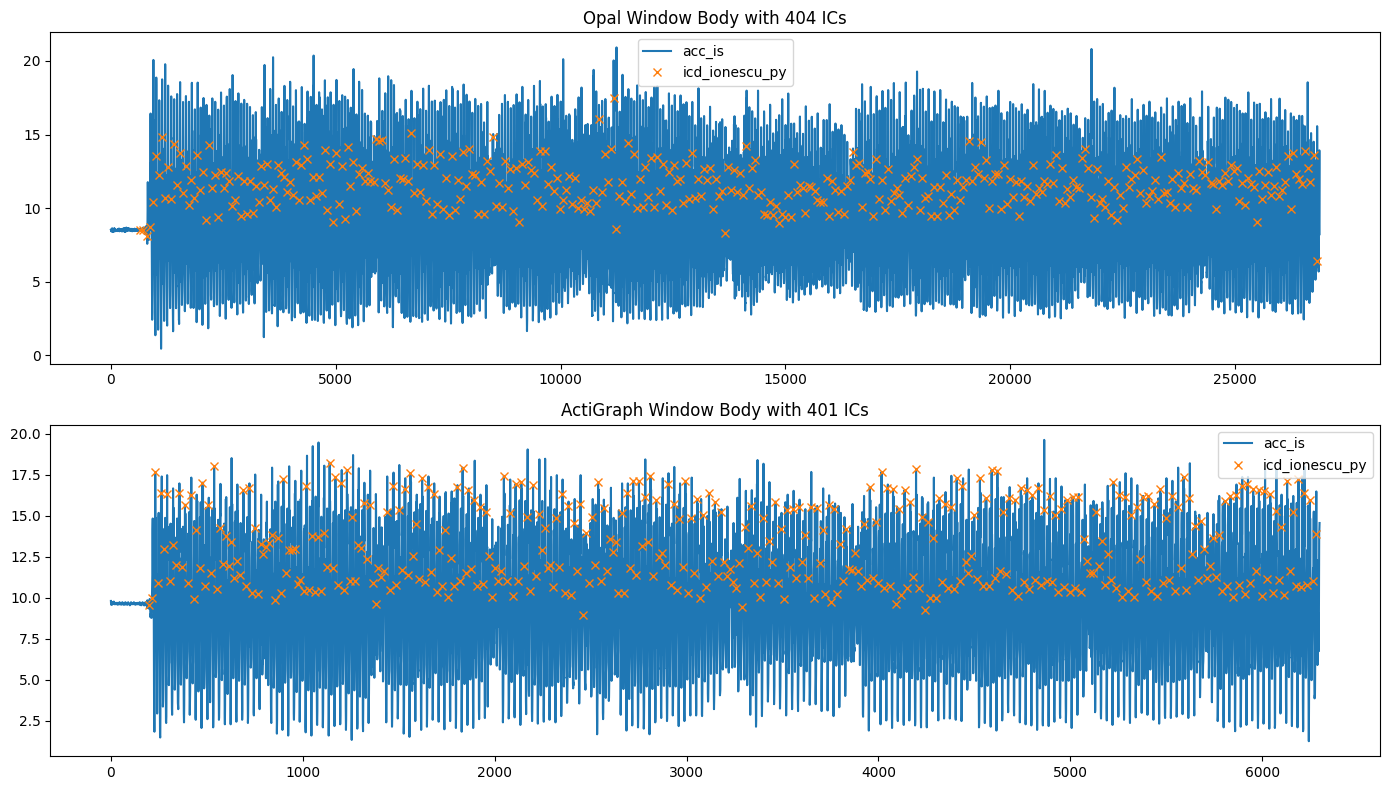

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-

Handling session subj2_lab


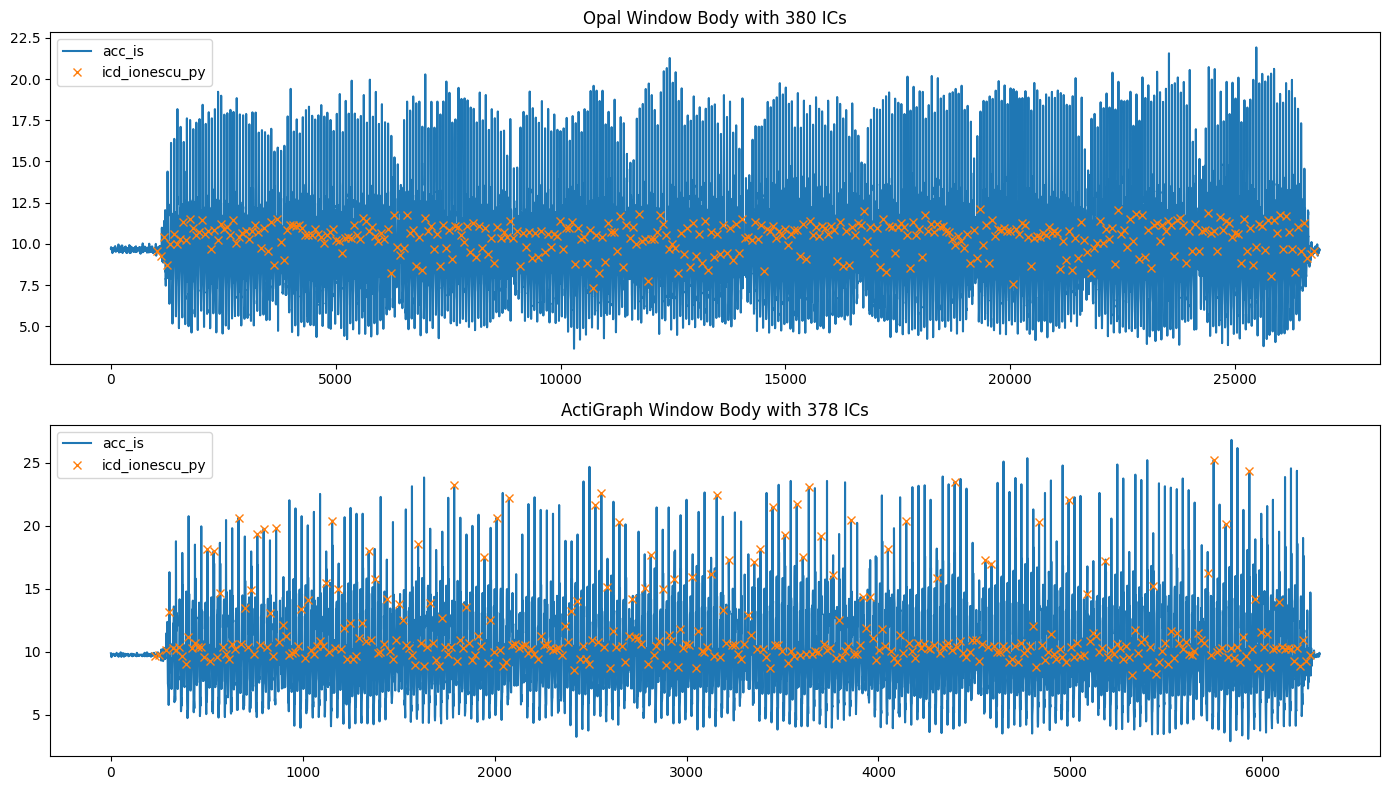

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-

Handling session subj1_outside


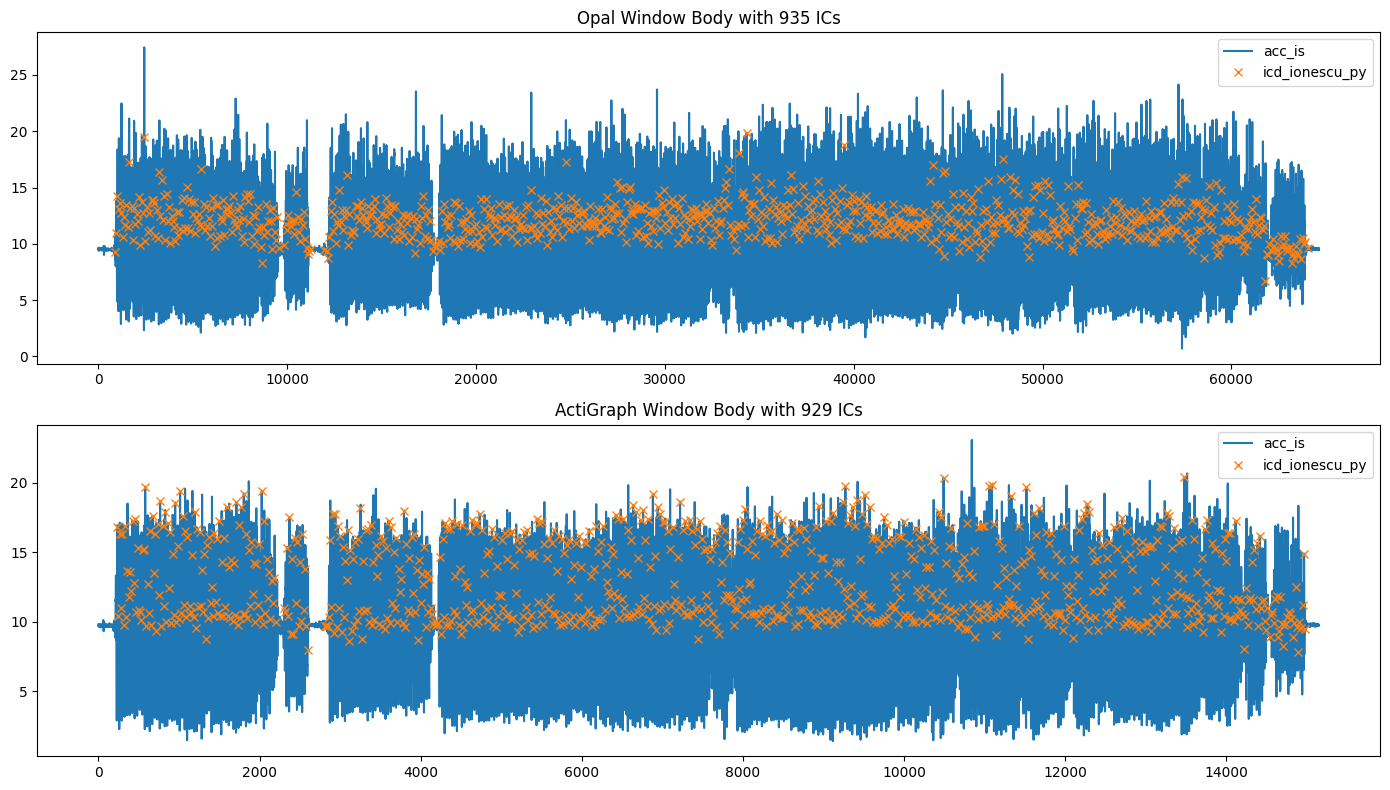

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-

Handling session subj2_outside


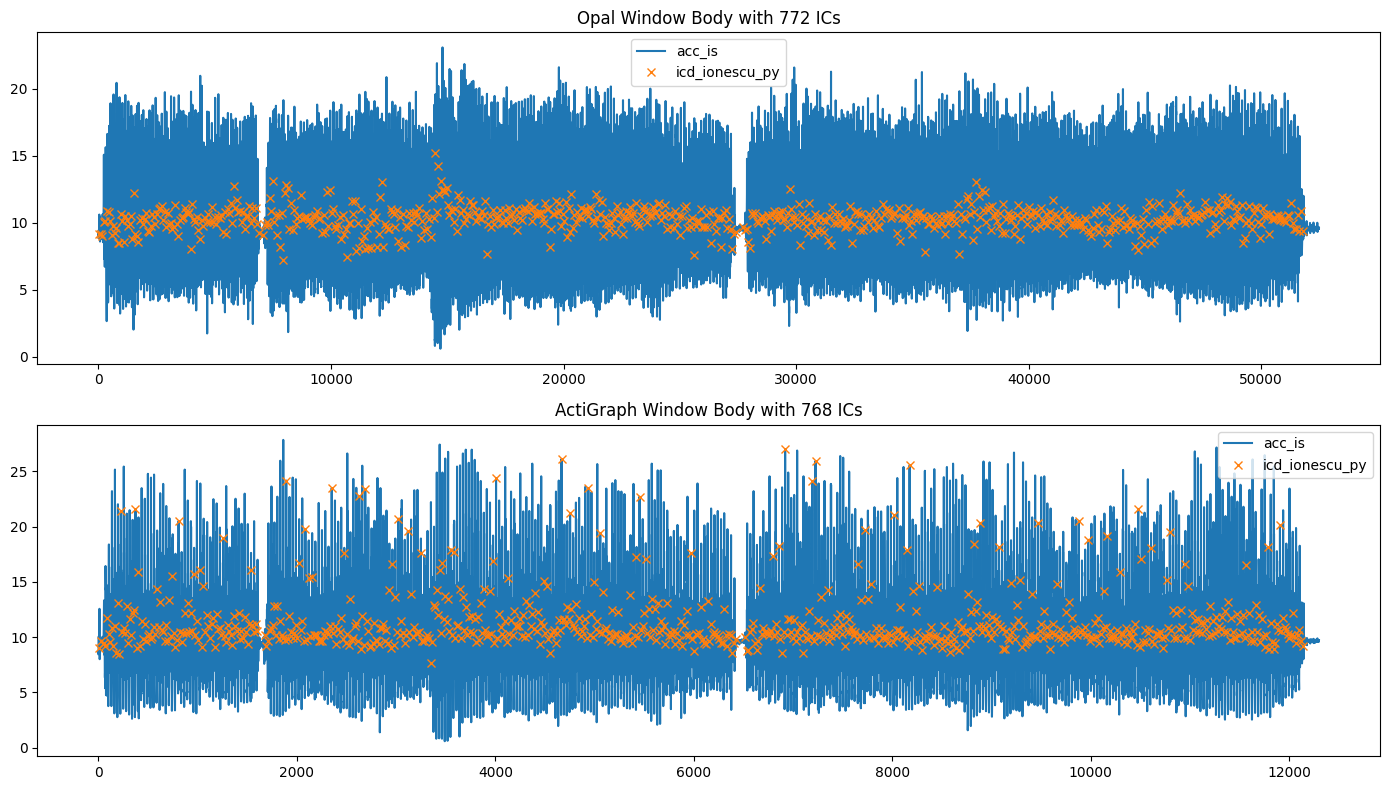

C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\imu_comparison\venv\lib\site-

All calculated


C:\project_local\imu_comparison\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(


In [2]:
from mobgap.pipeline import GsIterator
from mobgap.initial_contacts import IcdIonescu
from mobgap.cadence import CadFromIc
from mobgap.utils.conversions import to_body_frame
from mobgap.gait_sequences import GsdIluz
from mobgap.orientation_estimation._madgwick import MadgwickAHRS
from mobgap.stride_length import SlZijlstra
from mobgap.walking_speed import WsNaive

cadence_results_opal_list = []
cadence_results_actigraph_list = []
stride_length_results_opal_list = []
stride_length_results_actigraph_list = []
stride_length_global_results_opal_list = []
stride_length_global_results_actigraph_list = []
walk_speed_global_results_opal_list = []
walk_speed_global_results_actigraph_list = []
for session in session_list:

    print(f"Handling session {session}")
    data_opal_window = session_opal_data[session]
    data_actigraph_window = session_actigraph_data[session]
    
    data_opal_window_body = to_body_frame(data_opal_window)
    data_actigraph_window_body = to_body_frame(data_actigraph_window)
    
    gsd_opal = GsdIluz()
    gsd_opal.detect(data=data_opal_window_body, sampling_rate_hz=fs_opal)
    
    gsd_actigraph = GsdIluz()
    gsd_actigraph.detect(data=data_actigraph_window_body, sampling_rate_hz=fs_actigraph)

    iterator = GsIterator()
    for (gs, data), result in iterator.iterate(data_opal_window_body, gsd_opal.gs_list_):
        result.ic_list = (
            IcdIonescu().detect(data, sampling_rate_hz=fs_opal).ic_list_
        )
    detected_ics_opal = iterator.results_.ic_list
    
    iterator = GsIterator()
    for (gs, data), result in iterator.iterate(data_actigraph_window_body, gsd_actigraph.gs_list_):
        result.ic_list = (
            IcdIonescu().detect(data, sampling_rate_hz=fs_actigraph).ic_list_
        )
    detected_ics_actigraph = iterator.results_.ic_list

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    
    # Plot for Opal data
    axs[0].plot(data_opal_window_body['acc_is'], label='acc_is')
    axs[0].plot(
        detected_ics_opal['ic'],
        data_opal_window_body['acc_is'].iloc[detected_ics_opal['ic']],
        'x',
        label='icd_ionescu_py'
    )
    axs[0].set_title(f"Opal Window Body with {len(detected_ics_opal['ic'])} ICs")
    axs[0].legend()
    
    # Plot for Actigraph data
    axs[1].plot(data_actigraph_window_body['acc_is'], label='acc_is')
    axs[1].plot(
        detected_ics_actigraph['ic'],
        data_actigraph_window_body['acc_is'].iloc[detected_ics_actigraph['ic']],
        'x',
        label='icd_ionescu_py'
    )
    axs[1].set_title(f"ActiGraph Window Body with {len(detected_ics_actigraph['ic'])} ICs")
    axs[1].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

    # Let's get the ICs
    ics_opal = detected_ics_opal
    ics_actigraph = detected_ics_actigraph

    # Opal
    cad_from_ic = CadFromIc()
    cad_from_ic.calculate(
        data_opal_window_body,
        initial_contacts=ics_opal,
        sampling_rate_hz=fs_opal,
    )
    cadence_opal = cad_from_ic.cadence_per_sec_
    cadence_df = cad_from_ic.cadence_per_sec_
    cadence_df['subject'] = session.split("_")[0]
    cadence_df['session'] = session.split("_")[1]
    cadence_results_opal_list.append(cadence_df)

    # Actigraph
    cad_from_ic = CadFromIc()
    cad_from_ic.calculate(
        data_actigraph_window_body,
        initial_contacts=ics_actigraph,
        sampling_rate_hz=fs_actigraph,
    )
    cadence_actigraph = cad_from_ic.cadence_per_sec_
    cadence_df = cad_from_ic.cadence_per_sec_
    cadence_df['subject'] = session.split("_")[0]
    cadence_df['session'] = session.split("_")[1]
    cadence_results_actigraph_list.append(cadence_df)

    if "subj1" in session:
        sensor_height = 1.76*0.53
    elif "subj2" in session:
        sensor_height = 1.80*0.53
    else:
        sensor_height = np.nan

    # Opal
    sl_zijlstra = SlZijlstra(
        **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
    )
    sl_zijlstra.calculate(
        data=data_opal_window_body,
        initial_contacts=ics_opal,
        sensor_height_m=sensor_height,
        sampling_rate_hz=fs_opal,
    )
    stride_length_df = sl_zijlstra.stride_length_per_sec_
    stride_length_df['subject'] = session.split("_")[0]
    stride_length_df['session'] = session.split("_")[1]
    stride_length_results_opal_list.append(stride_length_df)
    
    # ActiGraph
    sl_zijlstra = SlZijlstra(
        **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
    )
    sl_zijlstra.calculate(
        data=data_actigraph_window_body,
        initial_contacts=ics_actigraph,
        sensor_height_m=sensor_height,
        sampling_rate_hz=fs_actigraph,
    )
    stride_length_df = sl_zijlstra.stride_length_per_sec_
    stride_length_df['subject'] = session.split("_")[0]
    stride_length_df['session'] = session.split("_")[1]
    stride_length_results_actigraph_list.append(stride_length_df)

    # Opal
    sl_zijlstra = SlZijlstra(
        orientation_method=MadgwickAHRS(beta=0.2),
        **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
    )
    sl_zijlstra.calculate(
        data=data_opal_window_body,
        initial_contacts=ics_opal,
        sensor_height_m=sensor_height,
        sampling_rate_hz=fs_opal,
    )
    stride_length_opal = sl_zijlstra.stride_length_per_sec_
    stride_length_df = sl_zijlstra.stride_length_per_sec_
    stride_length_df['subject'] = session.split("_")[0]
    stride_length_df['session'] = session.split("_")[1]
    stride_length_global_results_opal_list.append(stride_length_df)
    
    # ActiGraph
    sl_zijlstra = SlZijlstra(
        **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
    )
    sl_zijlstra.calculate(
        data=data_actigraph_window_body,
        initial_contacts=ics_actigraph,
        sensor_height_m=sensor_height,
        sampling_rate_hz=fs_actigraph,
    )
    stride_length_actigraph = sl_zijlstra.stride_length_per_sec_
    stride_length_df = sl_zijlstra.stride_length_per_sec_
    stride_length_df['subject'] = session.split("_")[0]
    stride_length_df['session'] = session.split("_")[1]
    stride_length_global_results_actigraph_list.append(stride_length_df)

    # Opal
    ws = WsNaive()
    ws.calculate(
        data_opal_window_body,
        initial_contacts=ics_opal,
        cadence_per_sec=cadence_opal,
        stride_length_per_sec=stride_length_opal,
        sampling_rate_hz=fs_opal,
    )
    walk_speed_opal = ws.walking_speed_per_sec_
    walk_speed_df = ws.walking_speed_per_sec_
    walk_speed_df['subject'] = session.split("_")[0]
    walk_speed_df['session'] = session.split("_")[1]
    walk_speed_global_results_opal_list.append(walk_speed_df)

    # ActiGraph
    ws = WsNaive()
    ws.calculate(
        data_actigraph_window_body,
        initial_contacts=ics_actigraph,
        cadence_per_sec=cadence_actigraph,
        stride_length_per_sec=stride_length_actigraph,
        sampling_rate_hz=fs_actigraph,
    )
    walk_speed_actigraph = ws.walking_speed_per_sec_
    walk_speed_df = ws.walking_speed_per_sec_
    walk_speed_df['subject'] = session.split("_")[0]
    walk_speed_df['session'] = session.split("_")[1]
    walk_speed_global_results_actigraph_list.append(walk_speed_df)


cadence_results_opal = pd.concat(cadence_results_opal_list)
cadence_results_actigraph = pd.concat(cadence_results_actigraph_list)
stride_length_results_opal = pd.concat(stride_length_results_opal_list)
stride_length_results_actigraph = pd.concat(stride_length_results_actigraph_list)
stride_length_global_results_opal = pd.concat(stride_length_global_results_opal_list)
stride_length_global_results_actigraph = pd.concat(stride_length_global_results_actigraph_list)
walk_speed_global_results_opal = pd.concat(walk_speed_global_results_opal_list)
walk_speed_global_results_actigraph = pd.concat(walk_speed_global_results_actigraph_list)
print("All calculated")

Text(0.5, 1.0, 'Lab session - Stride length with 407 Opal and 406 Actigraph values')

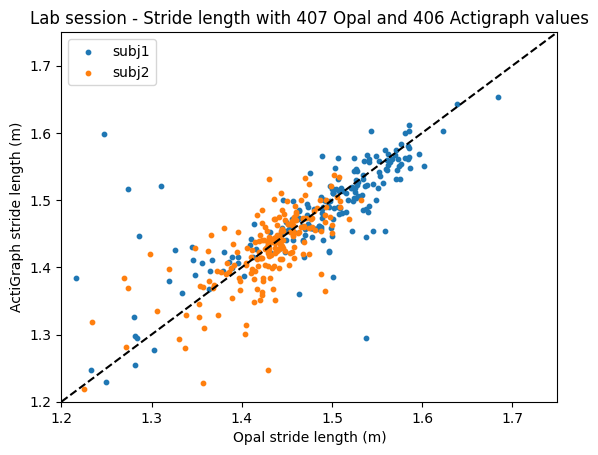

In [27]:
results_opal = stride_length_results_opal[stride_length_results_opal['session'] == 'lab']
results_actigraph = stride_length_results_actigraph[stride_length_results_actigraph['session'] == 'lab']

plt.figure()

lim_low = 1.2
lim_high = 1.75
x_vals = np.linspace(lim_low, lim_high, 100)

subjs = results_opal['subject'].unique()
for subj in subjs:
    results_opal_subj = results_opal[results_opal['subject'] == subj]
    results_actigraph_subj = results_actigraph[results_actigraph['subject'] == subj]
    plt.scatter(results_opal_subj['stride_length_m'], results_actigraph_subj['stride_length_m'], s=10)
plt.xlabel("Opal stride length (m)")
plt.ylabel("ActiGraph stride length (m)")
plt.xlim([lim_low, lim_high])
plt.ylim([lim_low, lim_high])
plt.plot(x_vals, x_vals, 'k--')
plt.legend(subjs)
plt.title(f"Lab session - Stride length with {results_opal.dropna().shape[0]} Opal and {results_actigraph.dropna().shape[0]} Actigraph values")

Text(0.5, 1.0, 'Lab session - Global stride length with 407 Opal and 406 Actigraph values')

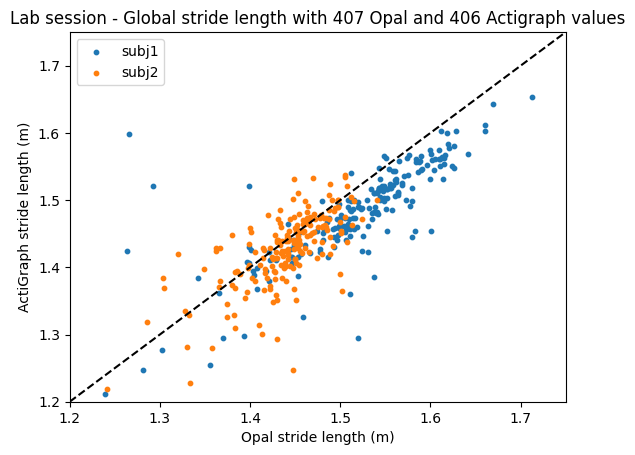

In [28]:
results_opal = stride_length_global_results_opal[stride_length_results_opal['session'] == 'lab']
results_actigraph = stride_length_global_results_actigraph[stride_length_results_actigraph['session'] == 'lab']

plt.figure()

lim_low = 1.2
lim_high = 1.75
x_vals = np.linspace(lim_low, lim_high, 100)

subjs = results_opal['subject'].unique()
for subj in subjs:
    results_opal_subj = results_opal[results_opal['subject'] == subj]
    results_actigraph_subj = results_actigraph[results_actigraph['subject'] == subj]
    plt.scatter(results_opal_subj['stride_length_m'], results_actigraph_subj['stride_length_m'], s=10)
plt.xlabel("Opal stride length (m)")
plt.ylabel("ActiGraph stride length (m)")
plt.xlim([lim_low, lim_high])
plt.ylim([lim_low, lim_high])
plt.plot(x_vals, x_vals, 'k--')
plt.legend(subjs)
plt.title(f"Lab session - Global stride length with {results_opal.dropna().shape[0]} Opal and {results_actigraph.dropna().shape[0]} Actigraph values")

Text(0.5, 1.0, 'Lab session - Global walking speed with 407 Opal and 406 Actigraph values')

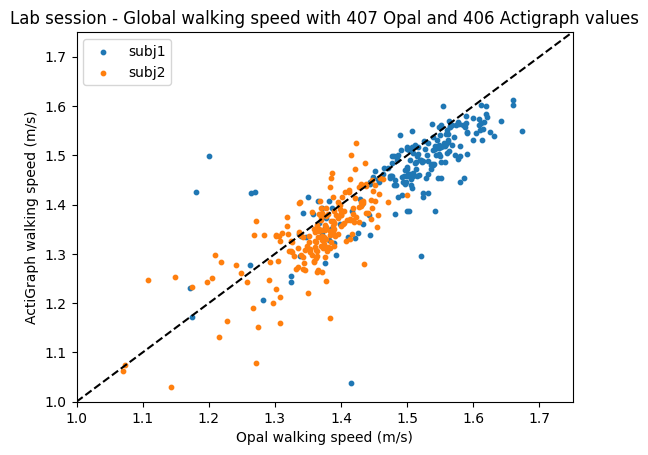

In [33]:
results_opal = walk_speed_global_results_opal[walk_speed_global_results_opal['session'] == 'lab']
results_actigraph = walk_speed_global_results_actigraph[walk_speed_global_results_actigraph['session'] == 'lab']

plt.figure()

lim_low = 1.0
lim_high = 1.75
x_vals = np.linspace(lim_low, lim_high, 100)

subjs = results_opal['subject'].unique()
for subj in subjs:
    results_opal_subj = results_opal[results_opal['subject'] == subj]
    results_actigraph_subj = results_actigraph[results_actigraph['subject'] == subj]
    plt.scatter(results_opal_subj['walking_speed_mps'], results_actigraph_subj['walking_speed_mps'], s=10)
plt.xlabel("Opal walking speed (m/s)")
plt.ylabel("ActiGraph walking speed (m/s)")
plt.xlim([lim_low, lim_high])
plt.ylim([lim_low, lim_high])
plt.plot(x_vals, x_vals, 'k--')
plt.legend(subjs)
plt.title(f"Lab session - Global walking speed with {results_opal.dropna().shape[0]} Opal and {results_actigraph.dropna().shape[0]} Actigraph values")

Text(0.5, 1.0, 'Outside session - Global stride length with 895 Opal and 892 Actigraph values')

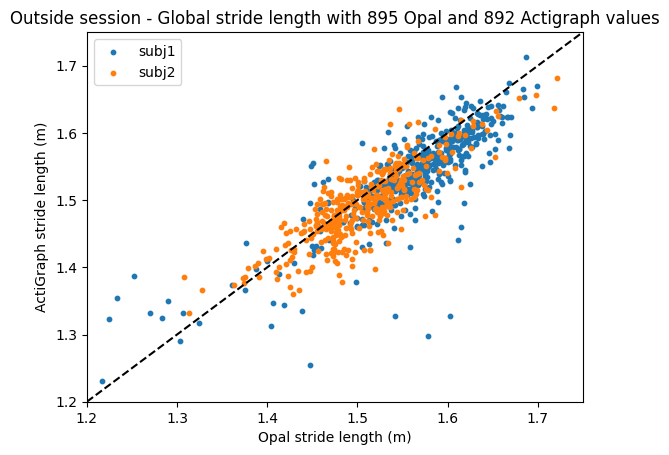

In [30]:
results_opal = stride_length_global_results_opal[stride_length_results_opal['session'] == 'outside']
results_actigraph = stride_length_global_results_actigraph[stride_length_results_actigraph['session'] == 'outside']

plt.figure()

lim_low = 1.2
lim_high = 1.75
x_vals = np.linspace(lim_low, lim_high, 100)

subjs = results_opal['subject'].unique()
for subj in subjs:
    results_opal_subj = results_opal[results_opal['subject'] == subj]
    results_actigraph_subj = results_actigraph[results_actigraph['subject'] == subj]
    plt.scatter(results_opal_subj['stride_length_m'], results_actigraph_subj['stride_length_m'], s=10)
plt.xlabel("Opal stride length (m)")
plt.ylabel("ActiGraph stride length (m)")
plt.xlim([lim_low, lim_high])
plt.ylim([lim_low, lim_high])
plt.plot(x_vals, x_vals, 'k--')
plt.legend(subjs)
plt.title(f"Outside session - Global stride length with {results_opal.dropna().shape[0]} Opal and {results_actigraph.dropna().shape[0]} Actigraph values")

Text(0.5, 1.0, 'Outside session - Global walking speed with 895 Opal and 892 Actigraph values')

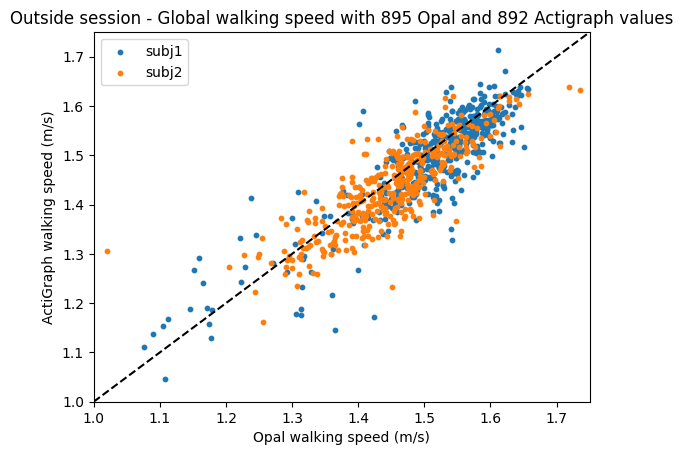

In [31]:
results_opal = walk_speed_global_results_opal[walk_speed_global_results_opal['session'] == 'outside']
results_actigraph = walk_speed_global_results_actigraph[walk_speed_global_results_actigraph['session'] == 'outside']

plt.figure()

lim_low = 1.0
lim_high = 1.75
x_vals = np.linspace(lim_low, lim_high, 100)

subjs = results_opal['subject'].unique()
for subj in subjs:
    results_opal_subj = results_opal[results_opal['subject'] == subj]
    results_actigraph_subj = results_actigraph[results_actigraph['subject'] == subj]
    plt.scatter(results_opal_subj['walking_speed_mps'], results_actigraph_subj['walking_speed_mps'], s=10)
plt.xlabel("Opal walking speed (m/s)")
plt.ylabel("ActiGraph walking speed (m/s)")
plt.xlim([lim_low, lim_high])
plt.ylim([lim_low, lim_high])
plt.plot(x_vals, x_vals, 'k--')
plt.legend(subjs)
plt.title(f"Outside session - Global walking speed with {results_opal.dropna().shape[0]} Opal and {results_actigraph.dropna().shape[0]} Actigraph values")